# Stock Trend Prediction

*** Description ***

This program downloads specified stocks' historical price data from Yahoo Finance and uses 2 machine learning models, KNN Classifier and XGBoost to classify price movement trend as Uptrend, Downtrend or No trend. At the end we predict future movement using latest stock data. This project includes retriving data, cleaning it and visualizing it before creating machine learning models and training/testing them using the clean data. Performance and Accuracy is calculated and compared over multiple versions of the models. In my findings, this model is more than 50% accurate (~60% average) which classifies it as a reliable model in analyzing and predicting future stock movement.

Libraries required:
- Python Standard Library
- Numpy
- Pandas
- Yfinance
- TA-Lib
- Matplotlib
- XGBoost
- Scikit Learn

In [14]:
# Importing libraries
import numpy as np
import pandas as pd
import yfinance as yf
import talib as ta
from datetime import datetime, date

# Disabling warnings
import warnings
warnings.filterwarnings("ignore")

# Stock ticker
ticker = 'AMZN'

# Downloading stock data from yahoo finance
df = yf.download(ticker, end=datetime.today(), progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]

# Check if any zero volumes are available
indexZeros = df[ df['Volume'] == 0 ].index

# Cleaning data for null values
df.drop(indexZeros , inplace=True)
df.loc[(df["Volume"] == 0 )]

,Open,High,Low,Close,Volume
Date,,,,,


In [15]:
# Calculating indicators using TA-Lib
df['MACD'] = ta.MACD(df['Close'])[0]
df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'], 20)
df['RSI'] = ta.RSI(df['Close'])
df['Average'] = ta.AVGPRICE(df['Open'], df['High'], df['Low'], df['Close']) #midprice
df['MA40'] = ta.SMA(df['Average'], 40)
df['MA80'] = ta.SMA(df['Average'], 80)
df['MA160'] = ta.SMA(df['Average'], 160)

In [16]:
# Number of days to calculate slope
backrolling = 6

# Calculating slope for indicators
df['slopeMA40'] = ta.LINEARREG_SLOPE(df['MA40'], backrolling)
df['slopeMA80'] = ta.LINEARREG_SLOPE(df['MA80'], backrolling)
df['slopeMA160'] = ta.LINEARREG_SLOPE(df['MA160'], backrolling)
df['slopeAverage'] = ta.LINEARREG_SLOPE(df['Average'], backrolling)
df['slopeRSI'] = ta.LINEARREG_SLOPE(df['RSI'], backrolling)
df['slopeMACD'] = ta.LINEARREG_SLOPE(df['MACD'], backrolling)

df.tail()

,Open,High,Low,Close,Volume,MACD,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,slopeAverage,slopeRSI,slopeMACD
Date,,,,,,,,,,,,,,,,,,
2022-12-27,84.970001,85.349998,83.000000,83.040001,57284000,-3.426447,3.586987,34.876981,84.090000,92.152188,105.553875,113.033928,-0.739230,-0.559140,-0.212747,-0.442500,0.292505,-0.056823
2022-12-28,82.800003,83.480003,81.690002,81.820000,58228600,-3.574356,3.497138,33.239777,82.447502,91.640813,104.975781,112.861846,-0.651727,-0.552992,-0.195967,-0.610500,-0.427733,-0.067528
2022-12-29,82.870003,84.550003,82.550003,84.180000,54995900,-3.461244,3.458781,39.186785,83.537502,91.220375,104.434406,112.715112,-0.558082,-0.552446,-0.178658,-0.567142,-0.118413,-0.062587
2022-12-30,83.120003,84.050003,82.470001,84.000000,62330000,-3.347538,3.371342,38.902142,83.410002,90.935688,103.880719,112.575696,-0.462987,-0.551031,-0.163255,-0.241071,0.696907,-0.017683
2023-01-03,85.459999,86.959999,84.209999,85.820000,76610700,-3.075118,3.350775,43.380409,85.612499,90.799188,103.341750,112.418417,-0.369016,-0.550408,-0.154993,0.160000,1.279621,0.043842


In [17]:
# Target flexible way
ask = 0.05      #ask
riskRatio = 2   #reward/risk ratio

# Identifying future trend for each day
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = 1-(low[line+i]/open[line+1])
            value2 = 1-(high[line+i]/open[line+1])
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            # Downtrend 
            if ( (valueOpenLow >= ask) and (-valueOpenHigh <= (ask/riskRatio)) ):
                trendcat[line] = 1
                break

            # Uptrend
            elif ( (valueOpenLow <= (ask/riskRatio)) and (-valueOpenHigh >= ask) ):
                trendcat[line] = 2
                break
            
            # No clear trend
            else:
                trendcat[line] = 0
            
    return trendcat

In [18]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(21, df)
df.head()

,Open,High,Low,Close,Volume,MACD,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,slopeAverage,slopeRSI,slopeMACD,mytarget
Date,,,,,,,,,,,,,,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000,NaN,NaN,NaN,0.110287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000,NaN,NaN,NaN,0.092318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000,NaN,NaN,NaN,0.085808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000,NaN,NaN,NaN,0.084375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000,NaN,NaN,NaN,0.076042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


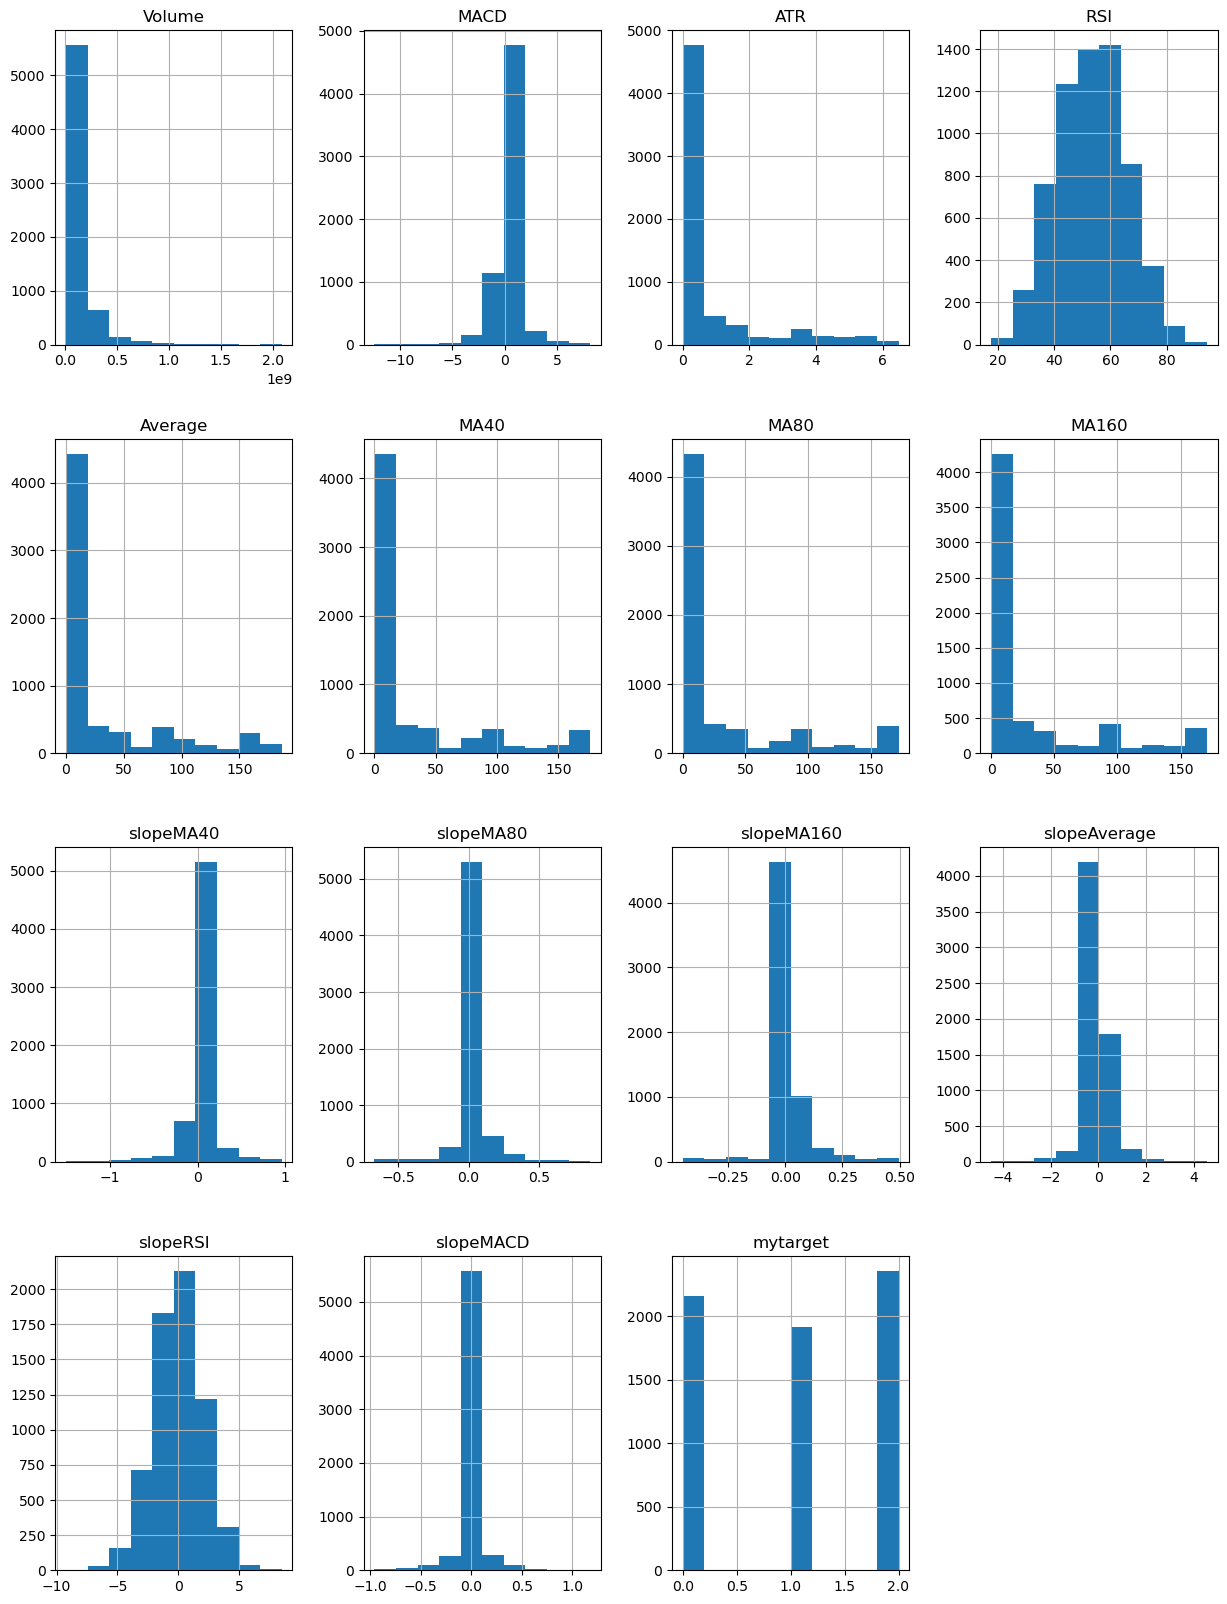

In [19]:
# Plotting charts to visualize frequency in indicators
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'MACD', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'slopeAverage', 'slopeRSI', 'slopeMACD', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

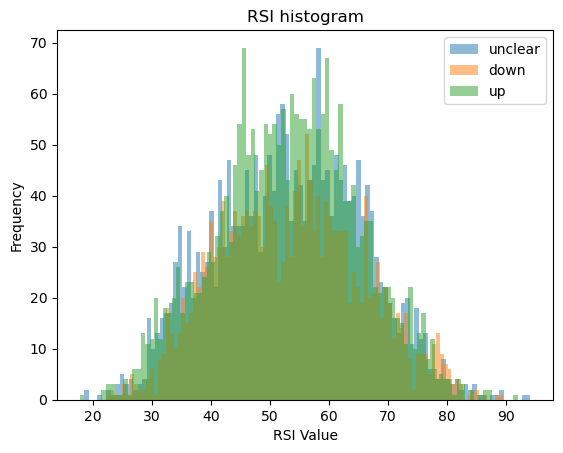

In [20]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.xlabel("RSI Value")
pyplot.ylabel("Frequency")
pyplot.title("RSI histogram")
pyplot.legend(loc='upper right')
pyplot.show()

In [21]:
# Attributes to train and test the model
attributes=['ATR', 'RSI', 'MACD', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'slopeAverage', 'slopeRSI', 'slopeMACD']

# Separating today's data for prediction
x_today = df_model[attributes][-1:]

# Dropping all rows with null values
df_model=df_model.dropna()

# Creating Input and Output dataset
x = df_model[attributes]
y = df_model["mytarget"]

df_model.tail()

,Volume,MACD,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,slopeAverage,slopeRSI,slopeMACD,mytarget
Date,,,,,,,,,,,,,,,
2022-11-22,62192000,-4.708885,4.907576,38.774275,92.510000,106.440250,119.143157,120.445231,-0.545655,-0.384595,-0.443092,-1.548143,-1.200995,0.135776,0.0
2022-11-23,59414700,-4.483151,4.749697,40.428527,93.695000,105.877062,118.625563,120.031042,-0.544952,-0.450934,-0.442209,-0.758286,-0.412467,0.112920,0.0
2022-11-25,35088600,-4.312639,4.580212,39.537869,93.675001,105.346875,118.070657,119.630924,-0.548782,-0.503638,-0.435801,-0.328143,0.081292,0.128119,0.0
2022-11-28,74943100,-4.086823,4.500701,40.594909,94.427500,104.852313,117.481438,119.247956,-0.547000,-0.542369,-0.422547,0.060500,0.418509,0.159809,0.0
2022-11-29,65567300,-3.985380,4.424166,38.539036,93.077501,104.311625,116.884406,118.878899,-0.538329,-0.558042,-0.403249,0.173429,0.280218,0.179397,2.0


## KNN Classification w/ Random sampling 

In [22]:
# KNN Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Training the model
model1 = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model1.fit(X_train, y_train)

# Predictions
y_pred_train = model1.predict(X_train)
y_pred_test = model1.predict(X_test)

# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))


print("Frequency:\n", df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model / Gambling
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Gambler Accuracy: %.2f%%" % (accuracy_test * 100.0))

# mytarget:
# 1: Downtrend
# 2: Uptrend
# 3: No Trend

Accuracy train: 40.20%
Accuracy test: 39.82%
Frequency:
 2.0    36.775738
0.0    33.567438
1.0    29.656824
Name: mytarget, dtype: float64
Gambler Accuracy: 33.92%


## XGBoost w/ Random Sampling

In [23]:
# Using XgBoost Classifier
from xgboost import XGBClassifier

# Training
model2 = XGBClassifier()
model2.fit(X_train, y_train)

# Prediction
pred_train = model2.predict(X_train)
pred_test = model2.predict(X_test)

# Accuracy
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

[00:11:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
****Train Results****
Accuracy: 98.1445%
****Test Results****
Accuracy: 58.7390%


## XGBoost with Sequential Sampling

_makes more sense for model to learn sequentially_

In [24]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

# Note: Above examples were made using random sampling 

#sequential sampling
train_index = int(0.8 * len(x))
X_train, X_test = x[:train_index], x[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model3 = XGBClassifier()
model3.fit(X_train, y_train)
pred_train = model3.predict(X_train)
pred_test = model3.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

[00:11:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
****Train Results****
Accuracy: 98.4836%
****Test Results****
Accuracy: 33.9984%


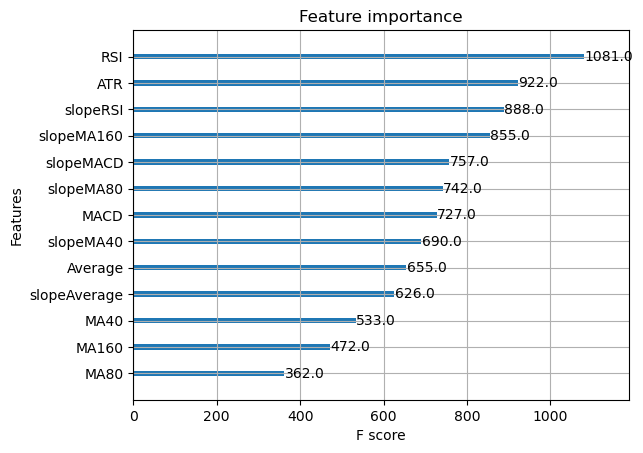

In [25]:
from matplotlib import pyplot
from xgboost import plot_importance

# plot feature importance
plot_importance(model2)
pyplot.show()

Model 1 prediction after 2023-01-04:  No Trend
Model 2 prediction after 2023-01-04:  Uptrend
Model 3 prediction after 2023-01-04:  Uptrend


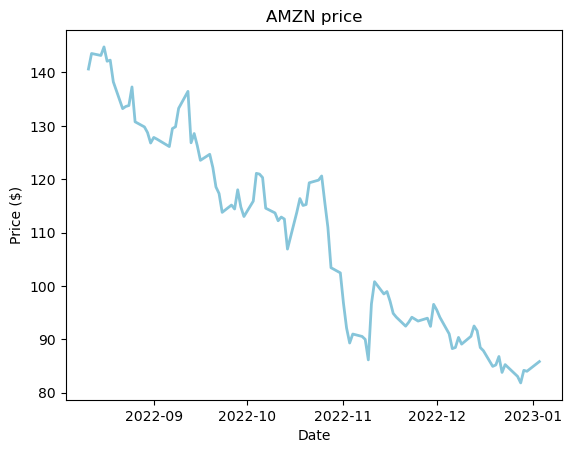

In [35]:
# Future Prediction
pyplot.plot(df.index[-100:], df['Close'][-100:], color='#86c5da', label='Stock Price', linewidth=2)
pyplot.ylabel('Price ($)')
pyplot.xlabel('Date')
pyplot.title(f'{ticker} price')

trend = ['No Trend', 'Downtrend', 'Uptrend']
print(f"Model 1 prediction after {date.today()}: ", trend[int(model1.predict(x_today))])
print(f"Model 2 prediction after {date.today()}: ", trend[int(model2.predict(x_today))])
print(f"Model 3 prediction after {date.today()}: ", trend[int(model3.predict(x_today))])